In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse, schedule

from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional, Union

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_5507/2268176252.py:19: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [3]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

## Tau 4 Calibration

1. First we run a Tau 3 Calibration to determine the duration for minimum photons
2. We use this to estimate the bandwidth added time
3. Then we use the Langevin Theory to determine the appropriate target photon population and corresponding tau_3
4. Then we do a Tau 4 Calibration to determine the exact tau 4 segment which gives minimum photons!

In [100]:
from helper_funcs.utils import *

# prelim tau 3 sweep

tau_3_center = 40.0 * ns
bandwidth_delay = 0.0 * ns
num_tau_3_exp = 6
tau_3_span = 15.0 * ns

freq_span = 10.0 * MHz
freq_center = 0.0 * MHz
num_freq_exp = 96
ac_freq_linspace = np.linspace(-0.5 * freq_span + freq_center, 0.5 * freq_span + freq_center, num_freq_exp)

tau_3_delay_dt = 64

tau_3_linspace = np.linspace(
    -0.5 * tau_3_span + tau_3_center + bandwidth_delay, 
    0.5 * tau_3_span + tau_3_center + bandwidth_delay, 
    num_tau_3_exp
)

print(tau_3_linspace/ns)
print(ac_freq_linspace/MHz)
print((get_closest_multiple_of(tau_3_linspace[4]/dt, 1))*dt/ns)

[32.5 35.5 38.5 41.5 44.5 47.5]
[-5.         -4.89473684 -4.78947368 -4.68421053 -4.57894737 -4.47368421
 -4.36842105 -4.26315789 -4.15789474 -4.05263158 -3.94736842 -3.84210526
 -3.73684211 -3.63157895 -3.52631579 -3.42105263 -3.31578947 -3.21052632
 -3.10526316 -3.         -2.89473684 -2.78947368 -2.68421053 -2.57894737
 -2.47368421 -2.36842105 -2.26315789 -2.15789474 -2.05263158 -1.94736842
 -1.84210526 -1.73684211 -1.63157895 -1.52631579 -1.42105263 -1.31578947
 -1.21052632 -1.10526316 -1.         -0.89473684 -0.78947368 -0.68421053
 -0.57894737 -0.47368421 -0.36842105 -0.26315789 -0.15789474 -0.05263158
  0.05263158  0.15789474  0.26315789  0.36842105  0.47368421  0.57894737
  0.68421053  0.78947368  0.89473684  1.          1.10526316  1.21052632
  1.31578947  1.42105263  1.52631579  1.63157895  1.73684211  1.84210526
  1.94736842  2.05263158  2.15789474  2.26315789  2.36842105  2.47368421
  2.57894737  2.68421053  2.78947368  2.89473684  3.          3.10526316
  3.21052632  3.315

576


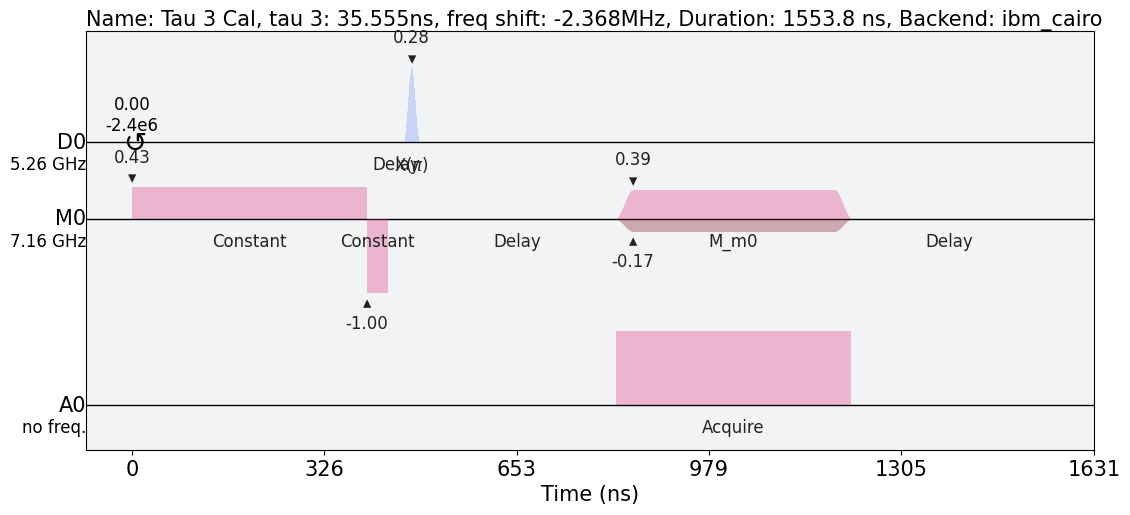

In [102]:
from helper_funcs.utils import *

tau_3_exp = []

for tau_3_sec in tau_3_linspace:
    tau_3_dt = get_closest_multiple_of(tau_3_sec/dt, 16)
    tau_3_sec = tau_3_dt * dt

    for freq_shift in ac_freq_linspace:
        with pulse.build(
            backend=backend,
            default_alignment='sequential',
            name=f'Tau 3 Cal, tau 3: {int(1e3*tau_3_sec / ns)/1e3}ns, freq shift: {int(1e3*freq_shift/MHz)/1e3}MHz'
        ) as tau_3_sched:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)

            pulse.shift_frequency(freq_shift, qubit_chan)

            pulse.play(
                pulse.Constant(duration=measure_pulse.duration, amp=measure_pulse.amp),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=tau_3_dt, amp=-1.0),
                meas_chan
            )
            pulse.delay(128, qubit_chan)
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(measure_delay.duration, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        tau_3_exp.append(tau_3_sched)

print(len(tau_3_exp))

tau_3_exp[121].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

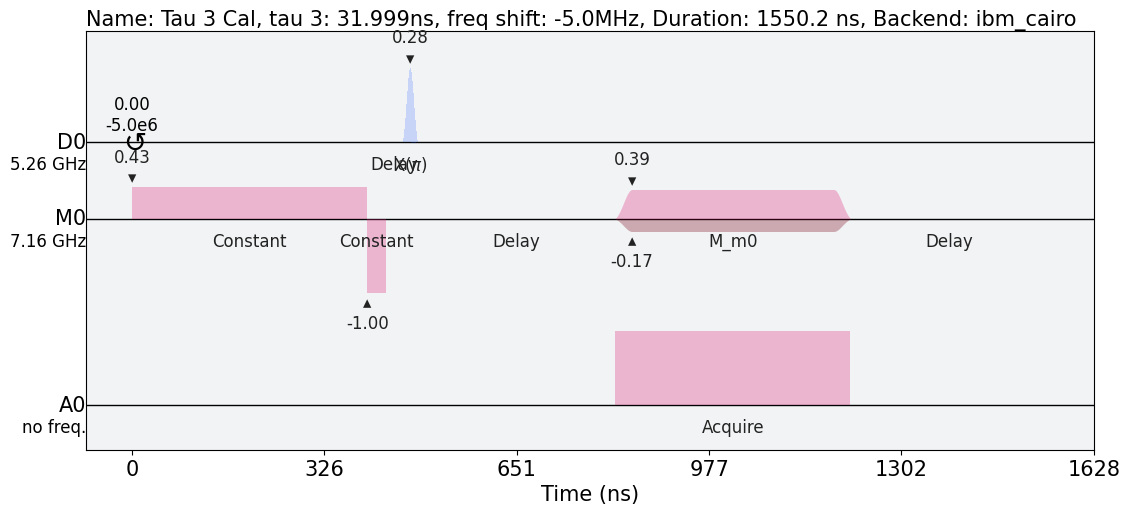

In [103]:
acquisition_checker(tau_3_exp)
exp_1, exp_2 = np.array(tau_3_exp).reshape(2, -1).tolist()

exp_1[0].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [105]:
num_shots = 4096
rep_delay = 499.0 * 1e-6

job_experiment = backend.run(exp_2, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued

KeyboardInterrupt: 

In [106]:
job_1 = provider.backend.retrieve_job('cpa82ybmbjng0085qbmg')
job_2 = provider.backend.retrieve_job('cpa830wyx18g008b5d70')

In [107]:
result_1 = get_results_arr(job_1.result(), qubit)
result_2 = get_results_arr(job_2.result(), qubit)

In [108]:
mean_1 = np.angle(np.mean(result_1, axis=-1))
mean_2 = np.angle(np.mean(result_2, axis=-1))

tau_3_res = np.concatenate((mean_1, mean_2)).reshape(num_tau_3_exp, -1)

In [109]:
from scipy.optimize import curve_fit

tau_3_fit_res = np.zeros_like(tau_3_res)
tau_3_freqs = np.zeros(len(tau_3_fit_res))

for ind, res_obj in enumerate(tau_3_res):
    init_params = [1., -1., 5., -2.]
    params, cov = curve_fit(gaussian_func_with_offset, ac_freq_linspace/MHz, res_obj, init_params, maxfev=2000)
    res = gaussian_func_with_offset(ac_freq_linspace/MHz, *params)
    tau_3_fit_res[ind] = res
    tau_3_freqs[ind] = params[1]

0.3529647735375589
41.5


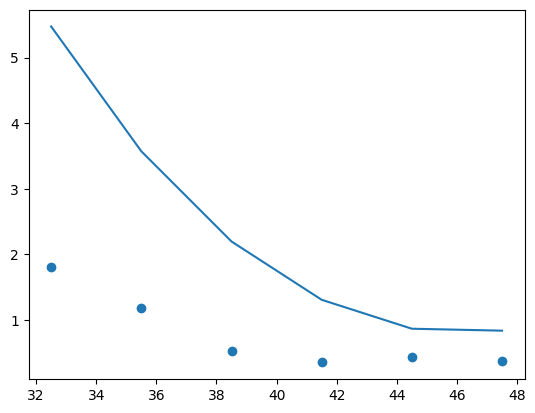

In [110]:
n0 = 42
k = 19.0
c = 0.65 * 2 * np.pi
u = 2.33

ts = tau_3_linspace/us - 0.01
theory_photons = n0 * (u**2 + (u + 1)**2 * np.exp(-k * ts) - 2 * u * (u + 1) * np.exp(-0.5 * k * ts) * np.cos(0.5 * c * ts)) - 0.5

photons = -tau_3_freqs/0.65
print(np.min(photons))
print(tau_3_linspace[np.argmin(photons)]/ns)

plt.scatter(tau_3_linspace/ns, -tau_3_freqs/0.65)
plt.plot(tau_3_linspace/ns, theory_photons)
plt.show()

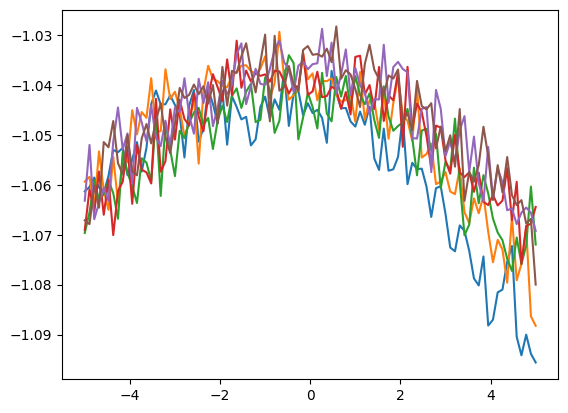

In [111]:
plt.plot(ac_freq_linspace/MHz, tau_3_res.T)